[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab9_transfer_learning.ipynb)

# Transfer Learning/Fine-Tuning

During training, neural networks often learn features that are useful for a wide variety of tasks. For example, the earliest layers of convolution networks often learn very basic visual features, such as edge detection. These task-agnostic features can be very useful when applied to other tasks. Transfer learning or fine-tuning is a technique that takes a network pretrained on one task and trains it on another. The idea is to tweak or tune the parameters on the new task, rather than making huge changes in learning. Fine-tuning is often quicker than learning on the new task from scratch, and can even lead to better overall performance and generalization.

Unfreezing a pretrained network is a fine-tuning technique that can be helpful when training a network on a difficult task with limited data.
If we allow the network to train its earliest layers immediately, then the earliest layers will forget all of the useful task-agnostic features they learned previously. So, rather than training all of the model weights at once, we learn on the last few layers (which are the most task-specific in the network). We can also gradually start training on the earlier layers as training progresses.

In this lab, you will compare unfreezing fine-tuning techniques against training a model from scratch. You will use the large ResNet-152 model to learn the small Bird Species Classification dataset.


### Grading

- 20% Analyze Dataset
- 20% Implementing `BirdNet`
- 20% Implementing `train()`
- 30% Running finetuning experiment
- 10% Answering questions


In [1]:
import zipfile
import os
import sys
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import time
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda")

## Analyze `BirdDataset`

Start by first downloading the dataset from Kaggle.

#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab.

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [3]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 Nov 16 22:43 kaggle.json


3. Copy the desired dataset locally

In [4]:
# Example download command for dataset found here: https://www.kaggle.com/akash2907/bird-species-classification
!kaggle datasets download -d akash2907/bird-species-classification

Dataset URL: https://www.kaggle.com/datasets/akash2907/bird-species-classification
License(s): CC-BY-NC-SA-4.0
100% 1.37G/1.37G [01:04<00:00, 24.1MB/s]
100% 1.37G/1.37G [01:04<00:00, 22.9MB/s]


The `BirdDataset` is implemented for you below. Instantiate a `train_dataset` and `val_dataset`.

In [5]:
class BirdDataset(Dataset):
    def __init__(self, zip_file='bird-species-classification.zip', size=256, train=True, upload=False):
        super(BirdDataset, self).__init__()

        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # We resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'

        if train:
            # The bird-species dataset mistakenly has a train_data folder inside of train_data
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'train_data', 'train_data'), transform=transforms.Compose([transforms.ToTensor()]))
        else:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'test_data', 'test_data'), transform=transforms.Compose([transforms.ToTensor()]))

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def resize(self, path, size=256):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)
                else:
                    print(f"else {name}")

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

In [6]:
train_dataset = BirdDataset(train=True)
val_dataset = BirdDataset(train=False)

Extracting bird-species-classification.zip
Resizing images


Print out the number of instances of each class in the `train_dataset` and `val_dataset`.

In [7]:
print(f"Number of training instances: {len(train_dataset)}")
print(f"Number of validation instances: {len(val_dataset)}")

Number of training instances: 150
Number of validation instances: 157


Print out a single image for each class in a 4x4 display.

In [8]:
class_names = train_dataset.dataset_folder.classes
print(class_names)
class_indices = train_dataset.dataset_folder.class_to_idx
print(class_indices)

['blasti', 'bonegl', 'brhkyt', 'cbrtsh', 'cmnmyn', 'gretit', 'hilpig', 'himbul', 'himgri', 'hsparo', 'indvul', 'jglowl', 'lbicrw', 'mgprob', 'rebimg', 'wcrsrt']
{'blasti': 0, 'bonegl': 1, 'brhkyt': 2, 'cbrtsh': 3, 'cmnmyn': 4, 'gretit': 5, 'hilpig': 6, 'himbul': 7, 'himgri': 8, 'hsparo': 9, 'indvul': 10, 'jglowl': 11, 'lbicrw': 12, 'mgprob': 13, 'rebimg': 14, 'wcrsrt': 15}


In [9]:
images_per_class = {}

for idx in range(len(train_dataset)):
    img, label = train_dataset[idx]
    class_name = class_names[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = img

    if len(images_per_class) == len(class_names):
        break

In [10]:
print(images_per_class)

{'blasti': tensor([[[0.4980, 0.4941, 0.4902,  ..., 0.3373, 0.3333, 0.3255],
         [0.5059, 0.5020, 0.4941,  ..., 0.3333, 0.3333, 0.3255],
         [0.4980, 0.5020, 0.4941,  ..., 0.3216, 0.3255, 0.3255],
         ...,
         [0.3765, 0.3412, 0.3961,  ..., 0.2000, 0.1686, 0.1490],
         [0.3647, 0.3412, 0.4078,  ..., 0.1882, 0.1647, 0.1647],
         [0.2980, 0.3020, 0.3216,  ..., 0.2078, 0.1922, 0.1843]],

        [[0.3922, 0.3882, 0.3882,  ..., 0.2784, 0.2784, 0.2745],
         [0.3961, 0.3922, 0.3843,  ..., 0.2784, 0.2784, 0.2745],
         [0.3922, 0.3882, 0.3843,  ..., 0.2745, 0.2745, 0.2706],
         ...,
         [0.3020, 0.2588, 0.3059,  ..., 0.1804, 0.1569, 0.1294],
         [0.3020, 0.2706, 0.3333,  ..., 0.1686, 0.1490, 0.1451],
         [0.2471, 0.2510, 0.2627,  ..., 0.1765, 0.1686, 0.1608]],

        [[0.3020, 0.2980, 0.2980,  ..., 0.2471, 0.2471, 0.2431],
         [0.2980, 0.2980, 0.2941,  ..., 0.2471, 0.2510, 0.2471],
         [0.3020, 0.3098, 0.2941,  ..., 0.2471,

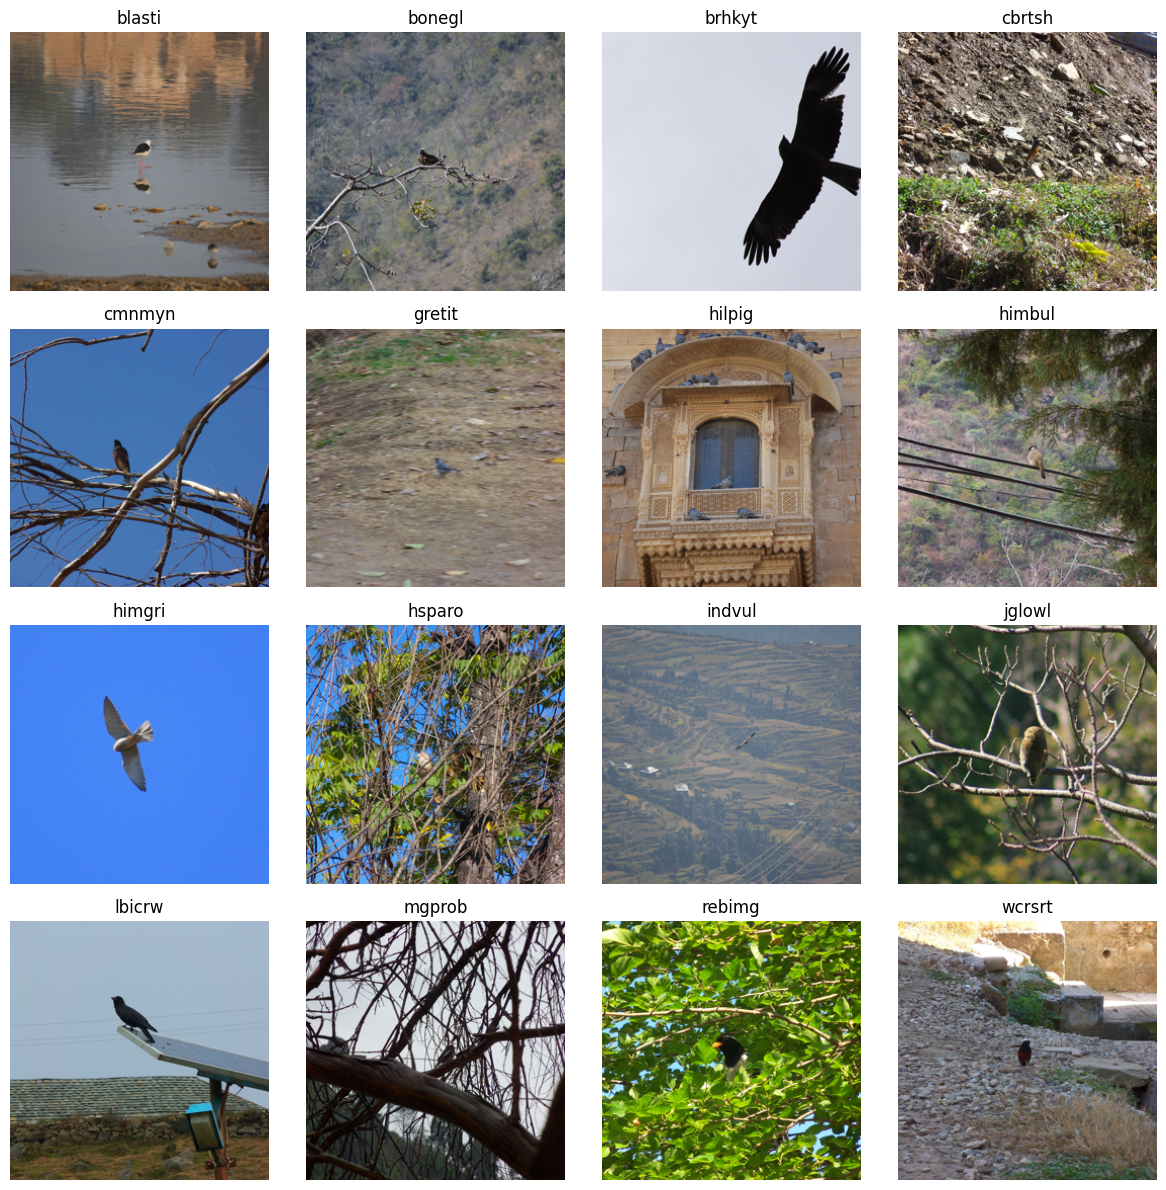

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for ax, class_name in zip(axes, class_names):
    img = images_per_class[class_name]
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

You will notice that not only do we have a small training dataset (150 images), some of the images are potentially difficult to classify because of how small the bird appears in the image. If you investigated the images further you would notice that many images of a given class are subsequent snapshots of the same bird. This will make generalization hard and overfitting easy, especially with a large network.

## Implement `BirdNet`


Implement the `BirdNet`: a wrapper class adding functionality to a (pretrained) `ResNet`.

### Implement `__init__()`
- The `BirdNet` should first instantiate a `models.resnet152` object and optionally, load in pretrained weights (look at https://pytorch.org/vision/stable/models.html for more information about using pretrained weights). We suggest using `models.ResNet152_Weights.IMAGENET1K_V1`.
- Overwrite the final layer in the ResNet to linearly map (with `nn.Linear`) the previous layers features to `n_classes`.
- Freeze all weights except the final layer. You can do this with calling `.requires_grad = False` on the parameters or calling `.requires_grad(False)` on the layers.


### Implement `unfreeze()`
Implement `unfreeze()` to unfreeze the last `n_layers` of your model. Do not treat the sequential or bottleneck layers in the ResNet as a single layer; we consider a convolutional layer or linear layer as a single layer. You may optionally treat a batchnorm layer as its own layer or as part of a conv/linear layer. ReLU layers do not have parameters, so they can't be frozen/unfrozen.


**Tip**: *You can print out a `models.resnet152` object to get an idea of how many input features are used in the last layer as well as the structure and naming convention used by the ResNet to know how to unfreeze `n_layers`.*


Create a temporary resnet152 model and print it here to see the structure of the network and the naming conventions. You can iterate over `.named_parameters()` to get the name and parameter object, respectively, to verify the naming scheme. This function can make your unfreezing function simpler.

In [12]:
temp_resnet = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
print(temp_resnet)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 171MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
for name, param in temp_resnet.named_parameters():
    print(name, param.size())

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [14]:
class BirdNet(nn.Module):
    def __init__(self, n_classes, pretrained_weights):
        super().__init__()
        if pretrained_weights is not None:
          self.net = models.resnet152(weights=pretrained_weights)
        else:
          self.net = models.resnet152(weights=None)

        # replace final layer
        num_ftrs = self.net.fc.in_features
        self.net.fc = nn.Linear(num_ftrs, n_classes)

        # freeze all weights except final layer
        for name, param in self.net.named_parameters():
          if "fc" not in name:
            param.requires_grad = False
          else:
            param.requires_grad = True

    def unfreeze(self, n_layers):
        layers = []
        for name, module in self.net.named_modules():
          if isinstance(module, (nn.Conv2d, nn.Linear)):
                layers.append((name, module))

        # unfreeze the last n_layers
        for name, module in layers[-n_layers:]:
          for param in module.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.net(x)

In [15]:
n_classes = 16
model = BirdNet(n_classes=n_classes, pretrained_weights=models.ResNet152_Weights.IMAGENET1K_V1)

In [16]:
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print("Trainable parameters before unfreeze:", trainable_params)

Trainable parameters before unfreeze: ['net.fc.weight', 'net.fc.bias']


In [17]:
model.unfreeze(n_layers=3)
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print("Trainable parameters after unfreezing last 3 layers:", trainable_params)

Trainable parameters after unfreezing last 3 layers: ['net.layer4.2.conv2.weight', 'net.layer4.2.conv3.weight', 'net.fc.weight', 'net.fc.bias']


## Training

In [18]:
@torch.no_grad()
def accuracy(y_hat, y_truth):
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc.item()


@torch.no_grad()
def evaluate(model, loss_fn, val_loader):
    val_losses = 0
    val_accs = 0
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()

    for x, y_truth in val_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x)
        val_losses += loss_fn(y_hat, y_truth).item() * len(x)
        val_accs += accuracy(y_hat, y_truth) * len(x)

    model.train()
    return val_losses/len(val_dataset), val_accs/len(val_dataset)


Implement the `train()` function. Keep track of the usual performance metrics (training/validation losses and accuracies) and additionally keep track of how long, in seconds, training took (this is referred to as wallclock training time).

There are two additional arguments in `train()`: `slowly_unfreeze` and `unfreeze_interval`.
 If `slowly_unfreeze=True` then for every `unfreeze_interval` number of steps you should unfreeze an additional layer from your model.

In [50]:
def train(model, optimizer, n_optimization_steps, log_interval, slowly_unfreeze, unfreeze_interval, train_loader, val_loader, loss_fn):
  model.to(device)
  model.train()
  start_time = time.time()
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  times = []

  step = 0
  layers_unfrozen = 0

  while step < n_optimization_steps:
      for x_batch, y_batch in train_loader:
          if step >= n_optimization_steps:
              break

          x_batch, y_batch = x_batch.to(device), y_batch.to(device)

          optimizer.zero_grad()
          y_hat = model(x_batch)
          loss = loss_fn(y_hat, y_batch)
          loss.backward()
          optimizer.step()

          # training losses and accuracy
          train_losses.append(loss.item())
          acc = accuracy(y_hat, y_batch)
          train_accs.append(acc)

          step += 1

          # slowly unfreeze layers if true
          if slowly_unfreeze and (step % unfreeze_interval == 0):
            layers_unfrozen += 1
            model.unfreeze(n_layers=layers_unfrozen)
            print(f"Unfroze {layers_unfrozen} layers at step {step}")

          # validation set
          if step % log_interval == 0:
            val_loss, val_acc = evaluate(model, loss_fn, val_loader)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            elapsed_time = time.time() - start_time
            times.append(elapsed_time)
            print(f"Step {step}/{n_optimization_steps}, Train Loss: {loss.item():.4f}, Train Acc: {acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {elapsed_time:.2f}s")

  total_time = time.time() - start_time
  print(f"Total Training Time: {total_time:.2f}s")

  return {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'times': times,
    'total_time': total_time
  }

In [56]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
loss_fn = nn.CrossEntropyLoss()

To compare how well finetuning works you will perform a set of experiments. There are four models you will train for `n_trials >= 3`:
- `res-reinit`: A reinitialized (not pretrained) resnet model. This is the baseline.
- `res1`: A pretrained resnet model with only the last layer unfrozen.
- `res3`: A pretrained resnet model with the last 3 layers unfrozen.
- `res10-slow`: A pretrained resnet model with the last last 10 layers **slowly** unfrozen.

For each model average the results across the `n_trials` and plot the val accuracy across time for each model and print out the average wallclock time and time per optimization step (i.e. wallclock_time / optimization_step) . **Do not forget to recreate the model and optimizer between each trial.**


**Tip:** Make sure everything is implemented correctly before running all `n_trials` on all four models. We found that a learning rate of .001 worked well for 100 optimization steps.

In [57]:
n_trials = 3
n_optimization_steps = 100
log_interval = 20
learning_rate = 0.001

In [58]:
def experiment(model_name, n_layers_unfrozen=0, slowly_unfreeze = False, unfreeze_interval = 10):
  total_times = []
  val_accs_list = []

  for trial in range(n_trials):
    print(f"Trial {trial + 1} for {model_name}")

    if model_name == "res-reinit":
      model = BirdNet(n_classes=n_classes, pretrained_weights=None)
    else:
      model = BirdNet(n_classes=n_classes, pretrained_weights=models.ResNet152_Weights.IMAGENET1K_V1)
      if n_layers_unfrozen > 0:
        model.unfreeze(n_layers=n_layers_unfrozen)

    params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    metrics = train(model, optimizer, n_optimization_steps, log_interval, slowly_unfreeze, unfreeze_interval, train_loader, val_loader, loss_fn)

    total_times.append(metrics['total_time'])
    val_accs_list.append(metrics['val_accs'])

  avg_time = sum(total_times) / n_trials
  avg_time_per_step = avg_time / n_optimization_steps

  print(f"\nAverage Total Time for {model_name}: {avg_time:.2f}s")
  print(f"Average Time per Optimization Step: {avg_time_per_step:.4f}s")

  # Plot validation accuracy over time
  avg_val_accs = [sum(accs)/n_trials for accs in zip(*val_accs_list)]
  plt.plot(range(log_interval, n_optimization_steps + 1, log_interval), avg_val_accs, label=model_name)

Trial 1 for res-reinit
Step 20/100, Train Loss: 2.4137, Train Acc: 0.2727, Val Loss: 2.8621, Val Acc: 0.0955, Time: 7.07s
Step 40/100, Train Loss: 2.7931, Train Acc: 0.0455, Val Loss: 2.9561, Val Acc: 0.0955, Time: 14.07s
Step 60/100, Train Loss: 2.5010, Train Acc: 0.2273, Val Loss: 2.8181, Val Acc: 0.0955, Time: 21.16s
Step 80/100, Train Loss: 2.3979, Train Acc: 0.2273, Val Loss: 2.7909, Val Acc: 0.1465, Time: 28.25s
Step 100/100, Train Loss: 2.7486, Train Acc: 0.1364, Val Loss: 2.7241, Val Acc: 0.2038, Time: 35.38s
Total Training Time: 35.38s
Trial 2 for res-reinit
Step 20/100, Train Loss: 2.7643, Train Acc: 0.0455, Val Loss: 2.9238, Val Acc: 0.0955, Time: 7.21s
Step 40/100, Train Loss: 2.5481, Train Acc: 0.1818, Val Loss: 3.0338, Val Acc: 0.0955, Time: 14.35s
Step 60/100, Train Loss: 2.2823, Train Acc: 0.3182, Val Loss: 2.8078, Val Acc: 0.1083, Time: 21.55s
Step 80/100, Train Loss: 2.2302, Train Acc: 0.3636, Val Loss: 2.7977, Val Acc: 0.1401, Time: 28.77s
Step 100/100, Train Loss: 2

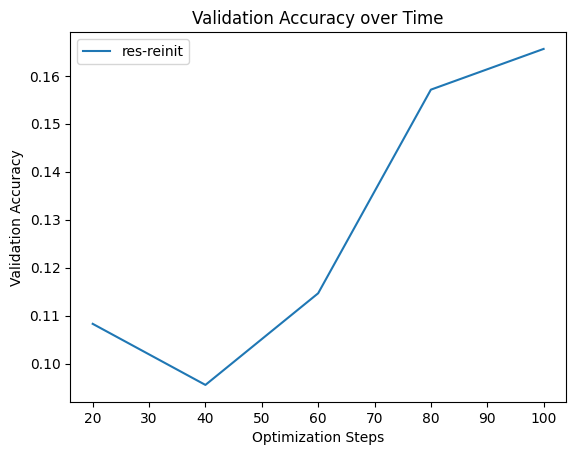

In [59]:
# res-reinit
experiment('res-reinit')

plt.xlabel('Optimization Steps')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Time')
plt.legend()
plt.show()

Trial 1 for res1
Step 20/100, Train Loss: 1.0707, Train Acc: 0.8182, Val Loss: 1.9653, Val Acc: 0.4140, Time: 7.30s
Step 40/100, Train Loss: 0.5364, Train Acc: 0.9091, Val Loss: 1.6866, Val Acc: 0.5414, Time: 14.62s
Step 60/100, Train Loss: 0.2603, Train Acc: 1.0000, Val Loss: 1.6560, Val Acc: 0.5541, Time: 21.89s
Step 80/100, Train Loss: 0.2001, Train Acc: 1.0000, Val Loss: 1.6204, Val Acc: 0.5605, Time: 29.24s
Step 100/100, Train Loss: 0.1513, Train Acc: 1.0000, Val Loss: 1.6357, Val Acc: 0.5732, Time: 36.56s
Total Training Time: 36.56s
Trial 2 for res1
Step 20/100, Train Loss: 1.0321, Train Acc: 0.8182, Val Loss: 1.9587, Val Acc: 0.4650, Time: 7.29s
Step 40/100, Train Loss: 0.6368, Train Acc: 0.8636, Val Loss: 1.6590, Val Acc: 0.5924, Time: 14.62s
Step 60/100, Train Loss: 0.3429, Train Acc: 0.9545, Val Loss: 1.6334, Val Acc: 0.5605, Time: 21.92s
Step 80/100, Train Loss: 0.2119, Train Acc: 1.0000, Val Loss: 1.6481, Val Acc: 0.5732, Time: 29.24s
Step 100/100, Train Loss: 0.1013, Train

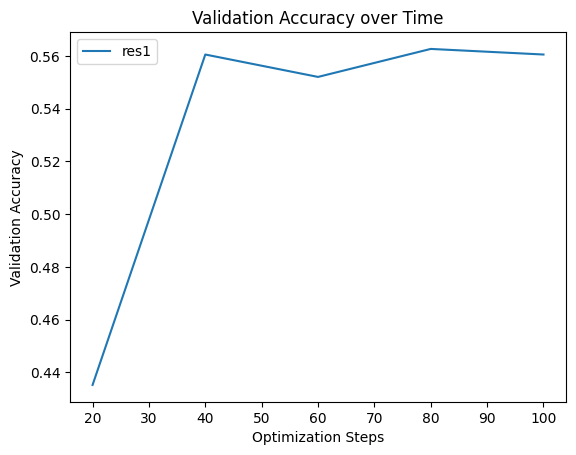

In [60]:
# res1
experiment('res1', n_layers_unfrozen=0)

plt.xlabel('Optimization Steps')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Time')
plt.legend()
plt.show()

Trial 1 for res3
Step 20/100, Train Loss: 0.0807, Train Acc: 1.0000, Val Loss: 1.9217, Val Acc: 0.5159, Time: 7.51s
Step 40/100, Train Loss: 0.0142, Train Acc: 1.0000, Val Loss: 1.7840, Val Acc: 0.5924, Time: 14.90s
Step 60/100, Train Loss: 0.0029, Train Acc: 1.0000, Val Loss: 1.7118, Val Acc: 0.5541, Time: 22.38s
Step 80/100, Train Loss: 0.0018, Train Acc: 1.0000, Val Loss: 1.6578, Val Acc: 0.5605, Time: 29.81s
Step 100/100, Train Loss: 0.0017, Train Acc: 1.0000, Val Loss: 1.6580, Val Acc: 0.5860, Time: 37.22s
Total Training Time: 37.22s
Trial 2 for res3
Step 20/100, Train Loss: 0.0807, Train Acc: 1.0000, Val Loss: 1.7727, Val Acc: 0.5414, Time: 7.43s
Step 40/100, Train Loss: 0.0096, Train Acc: 1.0000, Val Loss: 1.6863, Val Acc: 0.6051, Time: 14.83s
Step 60/100, Train Loss: 0.0062, Train Acc: 1.0000, Val Loss: 1.6207, Val Acc: 0.6178, Time: 22.24s
Step 80/100, Train Loss: 0.0033, Train Acc: 1.0000, Val Loss: 1.6398, Val Acc: 0.6051, Time: 29.66s
Step 100/100, Train Loss: 0.0017, Train

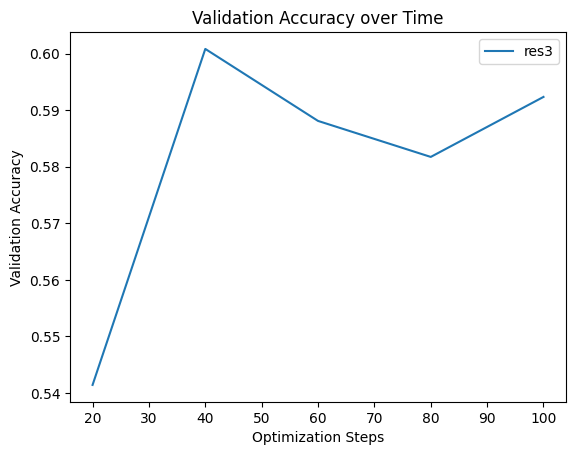

In [61]:
# res3
experiment('res3', n_layers_unfrozen=3)

plt.xlabel('Optimization Steps')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Time')
plt.legend()
plt.show()

Trial 1 for res10-slow
Unfroze 1 layers at step 10
Unfroze 2 layers at step 20
Step 20/100, Train Loss: 1.1728, Train Acc: 0.8636, Val Loss: 2.0323, Val Acc: 0.4204, Time: 7.28s
Unfroze 3 layers at step 30
Unfroze 4 layers at step 40
Step 40/100, Train Loss: 0.5215, Train Acc: 1.0000, Val Loss: 1.6684, Val Acc: 0.5287, Time: 14.70s
Unfroze 5 layers at step 50
Unfroze 6 layers at step 60
Step 60/100, Train Loss: 0.3267, Train Acc: 1.0000, Val Loss: 1.6508, Val Acc: 0.5414, Time: 22.23s
Unfroze 7 layers at step 70
Unfroze 8 layers at step 80
Step 80/100, Train Loss: 0.2263, Train Acc: 1.0000, Val Loss: 1.6306, Val Acc: 0.5478, Time: 29.82s
Unfroze 9 layers at step 90
Unfroze 10 layers at step 100
Step 100/100, Train Loss: 0.2172, Train Acc: 1.0000, Val Loss: 1.6808, Val Acc: 0.5287, Time: 37.61s
Total Training Time: 37.61s
Trial 2 for res10-slow
Unfroze 1 layers at step 10
Unfroze 2 layers at step 20
Step 20/100, Train Loss: 1.0552, Train Acc: 0.9091, Val Loss: 2.0344, Val Acc: 0.4076, T

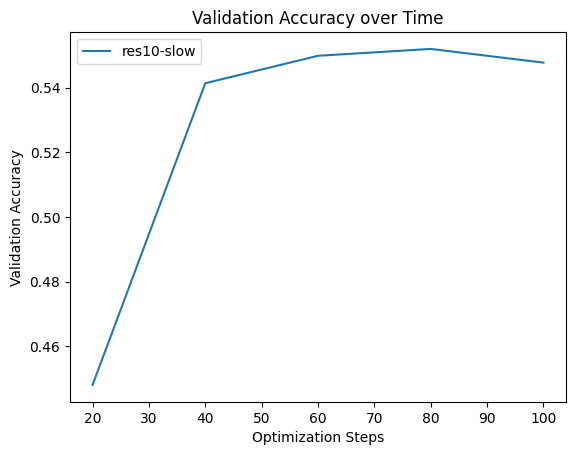

In [62]:
# res10-slow
experiment('res10-slow', slowly_unfreeze=True, unfreeze_interval=10)

plt.xlabel('Optimization Steps')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Time')
plt.legend()
plt.show()

### Questions
- Which model performed the best?
- How do the finetuned models compare to the reinitialized model in terms of time?
- Why are the ImageNet weights helpful to learning the Bird dataset?
- Why do we only unfreeze the last few layers?
- What are some pros and cons of pretraining?


### Which model performed the best?
- Based on the results from the graph it looks like the best performing models were res10, res3 and res1. Res3 starts out pretty high with a average validation accuracy around .60 but then it comes down to .58 in that steep curve in the graph. That really isn't much a of a drop though so I would probably stick with res3. I am suprised I thought that res10 would be the best model. Maybe I implemented something wrong with it or it just needs some more training time outside of 100 steps I am not sure but with this experiement I would take res3.

### How do the finetuned models compare to the reinitialized model in terms of time?
- the finetuned models were about a second slower in time actually but they were acheiving much better results than the base model from the begining. So this means that our overall training time is reduced because the base model would require a lot more extensive training with time.

### Why are the ImageNet weights helpful to learning the Bird dataset?
- They give us a better starting point in the space of trying to find the best parameters which means less training time and higher probability that we'll find the most optimal parameters and not get stuck somewhere.

### Why do we only unfreeze the last few layers?
- Because the last few layers are the most "task specific" layers. The earliest layers learn things such as edges, shapes, and so on, while the last few layers are very specific to our training task and what we are trying to classify. In this case we took a pretrained model that can do all that basic stuff and then finetined it towards classifing birds.

### What are some pros and cons of pretraining?
- pros
  - better starting point
  - less overall training time
  - a lot of things are already built for you
- cons
  - you are subject to any bias or weaknesses of the pretrained model
  - less customization



